In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math
import seaborn as sns

In [ ]:
# Récupérer les tickers des entreprises du S&P 500 depuis un fichier ou directement
# On peut utiliser un package ou une source externe pour obtenir cette liste
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()
# Remplacer les symboles problématiques
sp500_tickers = [ticker.replace('.', '-') for ticker in sp500_tickers]

# Télécharger les données des prix pour chaque actif du S&P 500
data = yf.download(sp500_tickers, start='2000-01-01', end='2024-10-01')['Adj Close']

# Calculer les rendements journaliers
returns = data.pct_change()

# Afficher les premiers résultats
print(returns.shape)

# Si vous souhaitez sauvegarder ce dataframe dans un fichier CSV
returns.to_csv('SP500_daily_returns.csv')

In [3]:
nan_counts=returns.isna().sum()
columns_to_keep = nan_counts[nan_counts <= 3].index
returns = returns[columns_to_keep]
returns=returns.dropna()
returns.shape

(6224, 354)

In [ ]:
def analyze_shock_volatility_correlation(returns):
    """
    Analyse l'effet des chocs négatifs et positifs sur la volatilité et
    calcule la corrélation entre les prix et la volatilité des rendements.

    :param returns: DataFrame des rendements journaliers (jours en index, actifs en colonnes).
    :return: DataFrame contenant la volatilité moyenne sous chocs négatifs, chocs positifs
             et la corrélation entre prix et volatilité pour chaque actif.
    """
    # Diviser les rendements en chocs négatifs (< 0) et positifs (> 0)
    negative_shocks = returns[returns < 0]
    positive_shocks = returns[returns > 0]

    # Calculer la volatilité (écart-type) pour les chocs négatifs et positifs
    negative_volatility = negative_shocks.std()
    positive_volatility = positive_shocks.std()

    # Calculer l'indice des prix accumulé à partir des rendements
    prices = (1 + returns).cumprod()

    # Calculer la volatilité roulante (par exemple sur une fenêtre de 21 jours)
    rolling_volatility = returns.rolling(window=21).std()

    # Calculer la corrélation entre les niveaux de prix et la volatilité des rendements
    price_volatility_correlation = prices.corrwith(rolling_volatility)

    # Créer un DataFrame avec les résultats
    result_df = pd.DataFrame({
        'Negative Volatility': negative_volatility,
        'Positive Volatility': positive_volatility,
        'Price-Volatility Correlation': price_volatility_correlation
    })

    return result_df

# Exemple d'utilisation
result_df = analyze_shock_volatility_correlation(returns)
print(result_df)

In [47]:
def calculate_volatility_after_shocks(returns, window_size=21, percentile=3):
    """
    Calcule la volatilité sur un mois après des chocs définis comme les rendements
    situés dans les 3e centiles les plus élevés ou les plus bas.

    :param returns: DataFrame avec les rendements journaliers (jours en index, actifs en colonnes).
    :param window_size: Taille de la fenêtre pour la volatilité (par défaut 21 jours).
    :param percentile: Percentile pour définir un choc (par défaut 3e centile).
    :return: DataFrame contenant la volatilité après les chocs pour chaque actif.
    """
    # Initialiser un DataFrame pour stocker les volatilités post-choc
    post_shock_volatility = pd.DataFrame(index=returns.index, columns=returns.columns)

    # Boucle sur chaque colonne (actif) du DataFrame
    for col in returns.columns:
        asset_returns = returns[col]
        
        # Définir les seuils pour les chocs
        lower_bound = np.percentile(asset_returns.dropna(), percentile)
        upper_bound = np.percentile(asset_returns.dropna(), 100 - percentile)
        
        # Identifier les chocs (rendements dans les 3e centiles supérieurs et inférieurs)
        shock_days = asset_returns[(asset_returns <= lower_bound) | (asset_returns >= upper_bound)].index
        
        # Pour chaque choc, calculer la volatilité sur le mois suivant (21 jours)
        for day in shock_days:
            if day in returns.index and returns.index.get_loc(day) + window_size < len(returns):
                # Calcul de la volatilité sur les 21 jours suivant le choc
                start = returns.index.get_loc(day)
                end = start + window_size
                post_shock_volatility.loc[day, col] = asset_returns.iloc[start:end].std()

    return post_shock_volatility

# Exemple d'utilisation
volatility_after_shocks = calculate_volatility_after_shocks(returns)
print(volatility_after_shocks)

                   A      AAPL       ABT      ACGL      ADBE       ADI  ADM  \
Date                                                                          
2000-01-04   0.04361  0.053036   0.02289       NaN  0.046549  0.042143  NaN   
2000-01-05  0.039596       NaN       NaN  0.032994       NaN       NaN  NaN   
2000-01-06       NaN  0.051628  0.023496       NaN       NaN       NaN  NaN   
2000-01-07  0.035706       NaN       NaN  0.027522       NaN       NaN  NaN   
2000-01-10  0.032198       NaN       NaN  0.025395       NaN   0.04779  NaN   
...              ...       ...       ...       ...       ...       ...  ...   
2024-09-24       NaN       NaN       NaN       NaN       NaN       NaN  NaN   
2024-09-25       NaN       NaN       NaN       NaN       NaN       NaN  NaN   
2024-09-26       NaN       NaN       NaN       NaN       NaN       NaN  NaN   
2024-09-27       NaN       NaN       NaN       NaN       NaN       NaN  NaN   
2024-09-30       NaN       NaN       NaN       NaN  

In [4]:
def sigmahat(Y,k=None):
    None, np.nan or int
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #
    #Post-Condition: Sigmahat dataframe is returned
    #Set df dimensions
    N = Y.shape[0]
    p = Y.shape[1]
    #default setting
    if (k is None or math.isnan(k)):
        Y = Y.sub(Y.mean(axis=0), axis=1)
        k = 1
    #vars
    n = N-k
    c = p/n
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n
    sample = (sample+sample.T)/2
    #make symmetrical
    #Spectral decomp
    lambda1, u = np.linalg.eigh(sample)
    lambda1 = lambda1.real.clip(min=0)
    dfu = pd.DataFrame(u,columns=lambda1) #create df with column names lambda
    dfu.sort_index(axis=1,inplace = True)
    lambda1 = dfu.columns
    h = (min(c**2,1/c**2)**0.35)/p**0.35
    #smoothing parameter
    invlambda = 1/lambda1[max(1,p-n+1)-1:p] #inverse of (non-null) eigenvalues
    dfl = pd.DataFrame()
    dfl['lambda'] = invlambda
    Lj = dfl[np.repeat(dfl.columns.values,min(p,n))]
    Lj = pd.DataFrame(Lj.to_numpy())
    Lj_i = Lj.subtract(Lj.T)
    #like 1/lambda_j
    #Reset column names
    #like (1/lambda_j)-(1/lambda_i)
    theta = Lj.multiply(Lj_i).div(Lj_i.multiply(Lj_i).add(Lj.multiply(Lj)*h**2)).mean(axis = 0)
    #smoothed Stein shrinker
    Htheta = Lj.multiply(Lj*h).div(Lj_i.multiply(Lj_i).add(Lj.multiply(Lj)*h**2)).mean(axis = 0)
    Atheta2 = theta**2+Htheta**2
    if p<=n:
        delta = 1 / ((1-c)**2*invlambda+2*c*(1-c)*invlambda*theta \
        +c**2*invlambda*Atheta2)
        delta = delta.to_numpy()
    else:
        delta0 = 1/((c-1)*np.mean(invlambda.to_numpy()))
        delta = np.repeat(delta0,p-n)
        delta = np.concatenate((delta, 1/(invlambda*Atheta2)), axis=None)
    deltaQIS = delta*(sum(lambda1)/sum(delta))
    temp1 = dfu.to_numpy()
    temp2 = np.diag(deltaQIS)
    temp3 = dfu.T.to_numpy().conjugate()
    #reconstruct covariance matrix
    #preserve trace
    sigmahat = pd.DataFrame(np.matmul(np.matmul(temp1,temp2),temp3), index=Y.columns, columns=Y.columns)
    return sigmahat


def optimal_shrinkage(Y):
    # Conversion des données en NumPy array
    Y_numpy = Y.values

    # Calcul de la matrice de covariance échantillonnée (empirique)
    sample_cov = np.cov(Y_numpy, rowvar=False)
    
    # Taille de l'échantillon et nombre de variables (actifs)
    n, p = Y_numpy.shape
    
    # Calcul de la variance de la matrice de covariance
    mean_Y = np.mean(Y_numpy, axis=0)
    centered_Y = Y_numpy - mean_Y
    var_cov = 0
    for i in range(n):
        yi = centered_Y[i, :]
        var_cov += np.outer(yi, yi) @ np.outer(yi, yi)
    var_cov = var_cov / (n ** 2)
    
    # Trace de la covariance échantillonnée
    trace_cov = np.trace(sample_cov)
    
    # Calcul du coefficient de rétrécissement optimal lambda
    pi_hat = np.sum((sample_cov - np.identity(p)) ** 2)
    gamma_hat = np.sum(var_cov)
    
    lambda_opt = max(0, min(1, gamma_hat / pi_hat))
    
    # Rétrécissement linéaire avec lambda optimal
    identity_matrix = np.identity(p)
    shrunk_cov = (1 - lambda_opt) * sample_cov + lambda_opt * identity_matrix
    
    # Convertir en DataFrame pour garder les noms des colonnes
    cov_df = pd.DataFrame(shrunk_cov, index=Y.columns, columns=Y.columns)
    
    return cov_df

def estimate_covariance_with_clipping(data_df):

    # Estimation de la matrice de covariance à partir des données (convertir en numpy array)
    data = data_df.values
    cov_matrix = np.cov(data, rowvar=False)
    n, p = data_df.shape
    # Calcul de la déviation standard moyenne (sigma)
    sigma = np.mean(np.std(data, axis=0))
    c=p/n
    # Décomposition en valeurs propres de la matrice de covariance
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Calcul des seuils lambda_+ et lambda_-
    lambda_plus = sigma**2 * (1 + np.sqrt(c))**2
    
    # Calcul de la valeur moyenne des valeurs propres à remplacer (pour Tr(\hat{\Sigma}_{clip}) = Tr(\hat{\Sigma}))
    num_clipped = np.sum(eigenvalues <= lambda_plus)
    trace_original = np.sum(eigenvalues)
    lambda_bar = (trace_original - np.sum(eigenvalues[eigenvalues > lambda_plus])) / num_clipped
    
    # Clipping des valeurs propres
    clipped_eigenvalues = np.array([
        eig if eig > lambda_plus else lambda_bar for eig in eigenvalues
    ])
    
    # Reconstruction de la matrice de covariance nettoyée
    cov_matrix_cleaned = np.dot(eigenvectors, np.dot(np.diag(clipped_eigenvalues), eigenvectors.T))
    
    # Convertir la matrice nettoyée en DataFrame avec les mêmes noms de colonnes que les données d'origine
    cleaned_cov_df = pd.DataFrame(cov_matrix_cleaned, index=data_df.columns, columns=data_df.columns)
    
    return cleaned_cov_df

In [5]:

def generate_multivariate_normal_data(cov_matrix, num_observations):

    # Si la matrice de covariance est un DataFrame, on la convertit en numpy array
    if isinstance(cov_matrix, pd.DataFrame):
        cov_matrix = cov_matrix.values
    
    # Dimension de la matrice de covariance
    num_variables = cov_matrix.shape[0]
    
    # Génération des données multivariées avec une moyenne nulle
    mean = np.zeros(num_variables)
    data = np.random.multivariate_normal(mean, cov_matrix, size=num_observations)
    
    # Création d'un DataFrame à partir des données générées
    columns = [f"Variable_{i+1}" for i in range(num_variables)]
    df = pd.DataFrame(data, columns=columns)
    
    return df

In [22]:
normal_data=generate_multivariate_normal_data(returns.iloc[-500:,:20].cov(), 1000)

In [23]:
L={}
L['reelle']=returns.iloc[-500:,:20].cov()
L['empirique']=[]
L['Linear']=[]
L['Non Linear']=[]
L['clipping']=[]
for i in range(0,1000,20):
    L['empirique'].append(normal_data.iloc[i:i+20,:].cov())
    L['Linear'].append(optimal_shrinkage(normal_data.iloc[i:i+20,:]))
    L['Non Linear'].append(sigmahat(normal_data.iloc[i:i+20,:], k=None))
    L['clipping'].append(estimate_covariance_with_clipping(normal_data.iloc[i:i+20,:]))


In [24]:
Liste=[L['reelle'],L['empirique'][0], L['Linear'][0], L['Non Linear'][10], L['clipping'][0]]

In [25]:
def plot_pca_variance_explained_multiple_cov_matrices(cov_matrices, labels):
    """
    Effectue une PCA à partir de plusieurs matrices de covariance et trace la variance expliquée par chaque composante principale.
    
    Args:
    cov_matrices (list of np.ndarray): Liste de matrices de covariance (n x n).
    labels (list of str): Liste des noms ou labels pour chaque matrice de covariance (doit avoir la même longueur que cov_matrices).
    
    Returns:
    None: Trace un graphique montrant la variance expliquée pour chaque estimateur de covariance.
    """
    plt.figure(figsize=(10, 6))
    
    for i, cov_matrix in enumerate(cov_matrices):
        # Décomposition en valeurs propres de la matrice de covariance
        eigenvalues, _ = np.linalg.eigh(cov_matrix)
        
        # Trier les valeurs propres dans l'ordre décroissant
        sorted_eigenvalues = np.sort(eigenvalues)[::-1]
        
        # Calcul de la variance expliquée
        explained_variance_ratio = sorted_eigenvalues / np.sum(sorted_eigenvalues)
        
        # Tracer la variance expliquée cumulée pour chaque matrice de covariance
        plt.step(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), where='mid', 
                 label=f'{labels[i]}', linewidth=2)
    
    plt.xlabel('Composantes principales')
    plt.ylabel('Variance expliquée cumulée')
    plt.title('Comparaison de la variance expliquée (PCA) pour différentes matrices de covariance')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

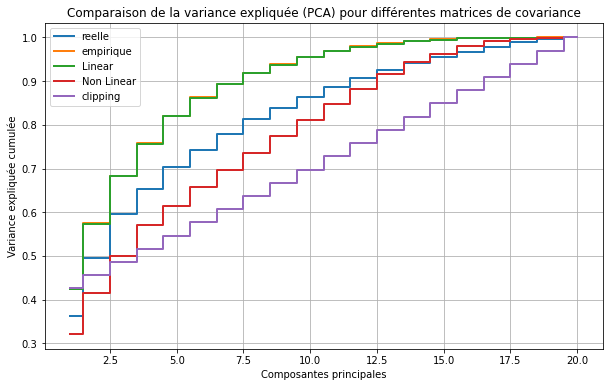

In [26]:
plot_pca_variance_explained_multiple_cov_matrices(Liste, ['reelle', 'empirique', 'Linear', 'Non Linear', 'clipping'])

In [27]:
D={}
D['empirique']=[]
D['Linear']=[]
D['Non Linear']=[]
D['clipping']=[]
for i in range(len(L['empirique'])):
    dist1 = L['empirique'][i].values - L['reelle'].values
    D['empirique'].append(np.sqrt(np.sum(dist1**2)))
    dist2 = L['Linear'][i].values - L['reelle'].values
    D['Linear'].append(np.sqrt(np.sum(dist2**2)))
    dist3 = L['Non Linear'][i].values - L['reelle'].values
    D['Non Linear'].append(np.sqrt(np.sum(dist3**2)))
    dist4 = L['clipping'][i].values - L['reelle'].values
    D['clipping'].append(np.sqrt(np.sum(dist4**2)))

In [28]:
def plot_series(D):
    plt.figure(figsize=(10, 6))  # Définir la taille du graphique
    for key, series in D.items():
        plt.plot(series, label=key)  # Tracer chaque série avec son label (clé du dictionnaire)
    
    plt.xlabel('Index')  # Nom de l'axe x
    plt.ylabel('Valeur')  # Nom de l'axe y
    plt.title('Courbes des séries stockées dans le dictionnaire')  # Titre du graphique
    plt.legend()  # Afficher la légende avec les clés
    plt.grid(True)  # Activer la grille
    plt.show()

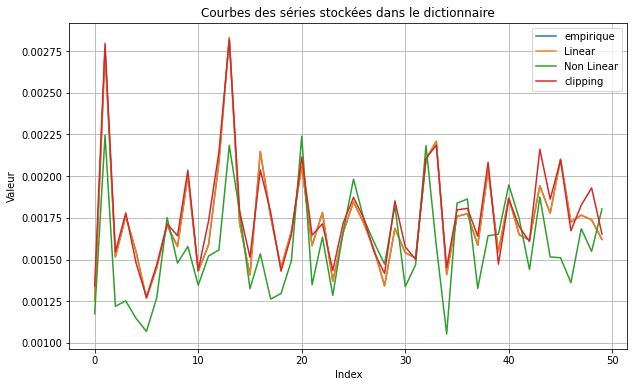

In [29]:
plot_series(D)

In [30]:
def minimum_variance_portfolio(cov_matrix):
    """
    Calcule les pondérations du portefeuille de variance minimale
    pour une matrice de covariance donnée.
    """
    ones = np.ones(len(cov_matrix))
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    weights = inv_cov_matrix @ ones / (ones.T @ inv_cov_matrix @ ones)
    return weights

def portfolio_standard_deviation(returns, cov_matrices):
    """
    Construit les portefeuilles de variance minimale à partir d'une liste
    de matrices de covariance et calcule l'écart-type (standard deviation)
    de la stratégie.
    
    :param returns: DataFrame avec les rendements journaliers par actifs.
    :param cov_matrices: Liste de matrices de covariance.
    :return: Écart-type de la stratégie de portefeuilles de variance minimale.
    """
    n = len(returns)  # Nombre total de jours dans les rendements
    L = len(cov_matrices)  # Nombre de matrices de covariance
    X = n // L  # Nombre de jours pendant lesquels chaque portefeuille est maintenu
    
    portfolio_returns = []  # Liste pour stocker les rendements des portefeuilles

    # Boucle sur chaque matrice de covariance pour créer un portefeuille
    for i, cov_matrix in enumerate(cov_matrices):
        # Calculer les pondérations du portefeuille de variance minimale
        weights = minimum_variance_portfolio(cov_matrix)
        
        # Calculer les rendements du portefeuille pour les X jours correspondants
        start = i * X
        end = (i + 1) * X if (i + 1) * X <= n else n  # S'assurer de ne pas dépasser n
        returns_subset = returns.iloc[start:end, :]  # Sous-ensemble des rendements
        portfolio_return = returns_subset @ weights  # Rendement du portefeuille sur cette période
        
        # Ajouter les rendements du portefeuille à la liste
        portfolio_returns.extend(portfolio_return)
    
    # Convertir en série pandas
    portfolio_returns = pd.Series(portfolio_returns)
    
    # Calcul de l'écart-type de la stratégie de portefeuilles
    strategy_std = portfolio_returns.std()
    
    return strategy_std*np.sqrt(252)

In [31]:
portfolio_standard_deviation(normal_data, [L['reelle'] for i in range(50)])

0.12787925621755272

In [32]:
portfolio_standard_deviation(normal_data, L['empirique'])

0.8224634328712737

In [33]:
portfolio_standard_deviation(normal_data, L['Linear'])

0.09358721307664

In [34]:
portfolio_standard_deviation(normal_data, L['clipping'])

0.12471819796421207

In [35]:
portfolio_standard_deviation(normal_data, L['Non Linear'])

0.0792098445504315

In [36]:

def calculate_period_std(returns, cov_matrices):
    """
    Calcule les écarts-types des portefeuilles de variance minimale pour chaque période.
    
    :param returns: DataFrame avec les rendements journaliers par actifs.
    :param cov_matrices: Liste de matrices de covariance.
    :return: Liste des écarts-types pour chaque période.
    """
    n = len(returns)  # Nombre total de jours dans les rendements
    L = len(cov_matrices)  # Nombre de matrices de covariance
    X = n // L  # Nombre de jours pendant lesquels chaque portefeuille est maintenu
    
    period_std_list = []  # Liste pour stocker les écarts-types des portefeuilles
    
    # Boucle sur chaque matrice de covariance pour créer un portefeuille
    for i, cov_matrix in enumerate(cov_matrices):
        # Calculer les pondérations du portefeuille de variance minimale
        weights = minimum_variance_portfolio(cov_matrix)
        
        # Calculer les rendements du portefeuille pour les X jours correspondants
        start = i * X
        end = (i + 1) * X if (i + 1) * X <= n else n  # S'assurer de ne pas dépasser n
        returns_subset = returns.iloc[start:end, :]  # Sous-ensemble des rendements
        portfolio_return = returns_subset @ weights  # Rendement du portefeuille sur cette période
        
        # Calculer l'écart-type des rendements du portefeuille
        period_std = portfolio_return.std()
        period_std_list.append(period_std)
    
    return period_std_list

def plot_std_distributions(returns, cov_matrices_list, labels):
    plt.figure(figsize=(10, 6))
    
    # Boucle sur chaque liste de matrices de covariance
    for cov_matrices, label in zip(cov_matrices_list, labels):
        # Calculer les écarts-types pour chaque période
        period_stds = calculate_period_std(returns, cov_matrices)
        
        # Tracer l'histogramme des écarts-types
        plt.hist(period_stds, bins=30, alpha=0.5, label=label)  # Histogramme classique avec 30 bins
    
    plt.xlabel('Écart-type')
    plt.ylabel('Fréquence')
    plt.title('Distribution des écarts-types des portefeuilles de variance minimale')
    plt.legend()
    plt.grid(True)
    plt.show()

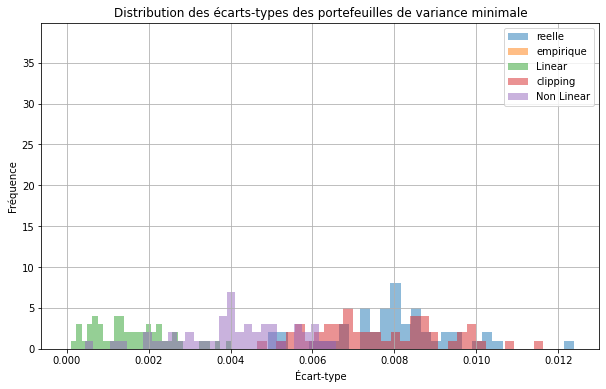

In [37]:
plot_std_distributions(normal_data, [[L['reelle'] for i in range(50)], L['empirique'], L['Linear'], L['clipping'], L['Non Linear'] ], ['reelle', 'empirique', 'Linear', 'clipping', 'Non Linear'])

In [38]:
def plot_eigenvalues_multiple(matrices, labels):
    """
    Trace un graphe des valeurs propres triées de plusieurs matrices sur un même graphique.
    
    :param matrices: Liste de matrices carrées (numpy arrays).
    :param labels: Liste de labels correspondant à chaque matrice pour la légende du graphique.
    """
    plt.figure(figsize=(10, 6))
    
    # Boucle sur chaque matrice pour calculer et tracer les valeurs propres
    for matrix, label in zip(matrices, labels):
        # Calculer les valeurs propres
        eigenvalues = np.linalg.eigvals(matrix)
        
        # Trier les valeurs propres dans l'ordre croissant
        eigenvalues_sorted = np.sort(eigenvalues)
        
        # Tracer les valeurs propres triées
        plt.plot(range(len(eigenvalues_sorted)), eigenvalues_sorted, marker='o', linestyle='-', label=label)
    
    # Ajouter des étiquettes et la légende
    plt.xlabel('Index des valeurs propres triées')
    plt.ylabel('Valeurs propres')
    plt.title('Valeurs propres triées de plusieurs matrices')
    plt.legend()
    plt.grid(True)
    plt.show()

In [39]:
def sigmahat(Y,k=None):
    None, np.nan or int
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #
    #Post-Condition: Sigmahat dataframe is returned
    #Set df dimensions
    N = Y.shape[0]
    p = Y.shape[1]
    #default setting
    if (k is None or math.isnan(k)):
        Y = Y.sub(Y.mean(axis=0), axis=1)
        k = 1
    #vars
    n = N-k
    c = p/n
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n
    sample = (sample+sample.T)/2
    #make symmetrical
    #Spectral decomp
    lambda1, u = np.linalg.eigh(sample)
    lambda1 = lambda1.real.clip(min=0)
    dfu = pd.DataFrame(u,columns=lambda1) #create df with column names lambda
    dfu.sort_index(axis=1,inplace = True)
    lambda1 = dfu.columns
    h = (min(c**2,1/c**2)**0.35)/p**0.35
    #smoothing parameter
    invlambda = 1/lambda1[max(1,p-n+1)-1:p] #inverse of (non-null) eigenvalues
    dfl = pd.DataFrame()
    dfl['lambda'] = invlambda
    Lj = dfl[np.repeat(dfl.columns.values,min(p,n))]
    Lj = pd.DataFrame(Lj.to_numpy())
    Lj_i = Lj.subtract(Lj.T)
    #like 1/lambda_j
    #Reset column names
    #like (1/lambda_j)-(1/lambda_i)
    theta = Lj.multiply(Lj_i).div(Lj_i.multiply(Lj_i).add(Lj.multiply(Lj)*h**2)).mean(axis = 0)
    #smoothed Stein shrinker
    Htheta = Lj.multiply(Lj*h).div(Lj_i.multiply(Lj_i).add(Lj.multiply(Lj)*h**2)).mean(axis = 0)
    Atheta2 = theta**2+Htheta**2
    if p<=n:
        delta = 1 / ((1-c)**2*invlambda+2*c*(1-c)*invlambda*theta \
        +c**2*invlambda*Atheta2)
        delta = delta.to_numpy()
    else:
        delta0 = 1/((c-1)*np.mean(invlambda.to_numpy()))
        delta = np.repeat(delta0,p-n)
        delta = np.concatenate((delta, 1/(invlambda*Atheta2)), axis=None)
    deltaQIS = delta*(sum(lambda1)/sum(delta))
    temp1 = dfu.to_numpy()
    temp2 = np.diag(deltaQIS)
    temp3 = dfu.T.to_numpy().conjugate()
    #reconstruct covariance matrix
    #preserve trace
    sigmahat = pd.DataFrame(np.matmul(np.matmul(temp1,temp2),temp3), index=Y.columns, columns=Y.columns)
    return lambda1, deltaQIS


def optimal_shrinkage(Y):
    # Conversion des données en NumPy array
    Y_numpy = Y.values

    # Calcul de la matrice de covariance échantillonnée (empirique)
    sample_cov = np.cov(Y_numpy, rowvar=False)
    
    # Taille de l'échantillon et nombre de variables (actifs)
    n, p = Y_numpy.shape
    
    # Calcul de la variance de la matrice de covariance
    mean_Y = np.mean(Y_numpy, axis=0)
    centered_Y = Y_numpy - mean_Y
    var_cov = 0
    for i in range(n):
        yi = centered_Y[i, :]
        var_cov += np.outer(yi, yi) @ np.outer(yi, yi)
    var_cov = var_cov / (n ** 2)
    
    # Trace de la covariance échantillonnée
    trace_cov = np.trace(sample_cov)
    
    # Calcul du coefficient de rétrécissement optimal lambda
    pi_hat = np.sum((sample_cov - np.identity(p)) ** 2)
    gamma_hat = np.sum(var_cov)
    
    lambda_opt = max(0, min(1, gamma_hat / pi_hat))
    
    # Rétrécissement linéaire avec lambda optimal
    identity_matrix = np.identity(p)
    shrunk_cov = (1 - lambda_opt) * sample_cov + lambda_opt * identity_matrix
    
    # Convertir en DataFrame pour garder les noms des colonnes
    cov_df = pd.DataFrame(shrunk_cov, index=Y.columns, columns=Y.columns)
    lambda1, u = np.linalg.eigh(sample_cov)
    lambda1 = lambda1.real.clip(min=0)
    return lambda1

def estimate_covariance_with_clipping(data_df):

    # Estimation de la matrice de covariance à partir des données (convertir en numpy array)
    data = data_df.values
    cov_matrix = np.cov(data, rowvar=False)
    n, p = data_df.shape
    # Calcul de la déviation standard moyenne (sigma)
    sigma = np.mean(np.std(data, axis=0))
    c=p/n
    # Décomposition en valeurs propres de la matrice de covariance
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Calcul des seuils lambda_+ et lambda_-
    lambda_plus = sigma**2 * (1 + np.sqrt(c))**2
    
    # Calcul de la valeur moyenne des valeurs propres à remplacer (pour Tr(\hat{\Sigma}_{clip}) = Tr(\hat{\Sigma}))
    num_clipped = np.sum(eigenvalues <= lambda_plus)
    trace_original = np.sum(eigenvalues)
    lambda_bar = (trace_original - np.sum(eigenvalues[eigenvalues > lambda_plus])) / num_clipped
    
    # Clipping des valeurs propres
    clipped_eigenvalues = np.array([
        eig if eig > lambda_plus else lambda_bar for eig in eigenvalues
    ])
    
    # Reconstruction de la matrice de covariance nettoyée
    cov_matrix_cleaned = np.dot(eigenvectors, np.dot(np.diag(clipped_eigenvalues), eigenvectors.T))
    
    # Convertir la matrice nettoyée en DataFrame avec les mêmes noms de colonnes que les données d'origine
    cleaned_cov_df = pd.DataFrame(cov_matrix_cleaned, index=data_df.columns, columns=data_df.columns)
    
    return clipped_eigenvalues

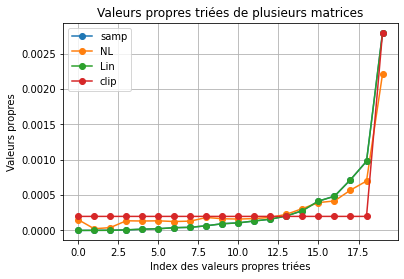

In [40]:
L1, L2= sigmahat(normal_data.iloc[:20,:],k=None)
L3= optimal_shrinkage(normal_data.iloc[:20,:])
L4= estimate_covariance_with_clipping(normal_data.iloc[:20,:])
plt.plot(range(len(L1)), L1, marker='o', linestyle='-', label='samp')
plt.plot(range(len(L1)), L2, marker='o', linestyle='-', label='NL')
plt.plot(range(len(L1)), L3, marker='o', linestyle='-', label='Lin')
plt.plot(range(len(L1)), L4, marker='o', linestyle='-', label='clip')
# Ajouter des étiquettes et la légende
plt.xlabel('Index des valeurs propres triées')
plt.ylabel('Valeurs propres')
plt.title('Valeurs propres triées de plusieurs matrices')
plt.legend()
plt.grid(True)
plt.show()